# Training base model for comparison

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import xml.etree.ElementTree as ET

from dotenv import load_dotenv
load_dotenv()

DETRAC_ROOT = os.getenv("DETRAC_ROOT") 
print(f"DETRAC_ROOT is set to: {DETRAC_ROOT}")

IMAGES_PATH = os.path.join(DETRAC_ROOT,"images")
ANNOTATIONS_PATH = os.path.join(DETRAC_ROOT,"annotations",  "DETRAC-Train-Annotations-XML")

DETRAC_ROOT is set to: /Users/victorhugogermano/Downloads/DETRAC


In [7]:

TARGET_SIZE = (64, 64)

def generate_cnn_training_dataset(annotations_dir, images_dir, target_size=TARGET_SIZE):
    annotations_dir = Path(annotations_dir)
    images_dir = Path(images_dir)
    if not annotations_dir.exists():
        raise FileNotFoundError(f"Annotations directory not found: {annotations_dir}")
    if not images_dir.exists():
        raise FileNotFoundError(f"Images directory not found: {images_dir}")

    print(f"Generating CNN training dataset from annotations in {annotations_dir} and images in {images_dir}...")
    
    crops, label_indices, metadata = [], [], []
    class_to_idx = {}

    for xml_path in sorted(annotations_dir.glob("*.xml")):
        seq_name = xml_path.stem
        seq_image_dir = images_dir / seq_name
        if not seq_image_dir.exists():
            continue

        tree = ET.parse(str(xml_path))
        for frame in tree.findall(".//frame"):
            frame_num = int(frame.attrib["num"])
            img_path = seq_image_dir / f"img{frame_num:05d}.jpg"
            if not img_path.exists():
                continue

            image = cv2.imread(str(img_path))
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h_img, w_img = image.shape[:2]

            target_list = frame.find("target_list")
            if target_list is None:
                continue

            for target in target_list.findall("target"):
                attr = target.find("attribute")
                vehicle_type = attr.attrib.get("vehicle_type", "unknown").lower() if attr is not None else "unknown"
                class_to_idx.setdefault(vehicle_type, len(class_to_idx))

                box = target.find("box")
                if box is None:
                    continue

                left = max(int(float(box.attrib["left"])), 0)
                top = max(int(float(box.attrib["top"])), 0)
                width = int(float(box.attrib["width"]))
                height = int(float(box.attrib["height"]))
                x2 = min(left + width, w_img)
                y2 = min(top + height, h_img)
                if x2 <= left or y2 <= top:
                    continue

                crop = image[top:y2, left:x2]
                if crop.size == 0:
                    continue
                resized = cv2.resize(crop, target_size, interpolation=cv2.INTER_LINEAR)

                label_idx = class_to_idx[vehicle_type]
                crops.append(resized)
                label_indices.append(label_idx)
                metadata.append(
                    {
                        "sequence": seq_name,
                        "frame": frame_num,
                        "image_path": str(img_path),
                        "bbox": (left, top, x2, y2),
                        "vehicle_type": vehicle_type,
                        "label_idx": label_idx,
                    }
                )

    if not crops:
        raise RuntimeError("No samples were extracted; check DETRAC paths and annotations.")

    cnn_images = np.stack(crops).astype("float32") / 255.0
    cnn_labels = np.array(label_indices, dtype="int32")
    num_classes = len(class_to_idx)
    cnn_labels_one_hot = np.eye(num_classes, dtype="float32")[cnn_labels]

    cnn_dataset = {
        "images": cnn_images,
        "labels": cnn_labels,
        "labels_one_hot": cnn_labels_one_hot,
        "class_to_idx": class_to_idx,
        "class_names": {idx: name for name, idx in class_to_idx.items()},
        "metadata": metadata,
    }
    print(f"Prepared {len(cnn_labels)} samples across {num_classes} classes from {len(metadata)} annotations.")
    return cnn_dataset

cnn_dataset = generate_cnn_training_dataset(ANNOTATIONS_PATH, IMAGES_PATH)

Generating CNN training dataset from annotations in /Users/victorhugogermano/Downloads/DETRAC/annotations/DETRAC-Train-Annotations-XML and images in /Users/victorhugogermano/Downloads/DETRAC/images...
Prepared 598281 samples across 4 classes from 598281 annotations.


In [13]:
import torch
from torch import nn

class VehicleClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

n_classes = len(cnn_dataset["class_to_idx"])
vehicle_model = VehicleClassifier(num_classes=n_classes)
print(vehicle_model)

VehicleClassifier(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum

In [14]:
from torch.utils.data import TensorDataset, DataLoader, random_split

images = cnn_dataset["images"]
labels = cnn_dataset["labels"]

torch_images = torch.from_numpy(np.transpose(images, (0, 3, 1, 2))).contiguous()
torch_labels = torch.from_numpy(labels).long()

dataset = TensorDataset(torch_images, torch_labels)
val_size = max(1, int(0.2 * len(dataset)))
train_size = len(dataset) - val_size
train_subset, val_subset = random_split(
    dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

BATCH_SIZE = 128
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

vehicle_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vehicle_model.parameters(), lr=1e-3)
NUM_EPOCHS = 5
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}


def run_epoch(loader, model, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)
    total_loss, total_correct, total_samples = 0.0, 0, 0
    with torch.set_grad_enabled(is_train):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            total_loss += loss.item() * xb.size(0)
            total_correct += (logits.argmax(1) == yb).sum().item()
            total_samples += xb.size(0)
    return total_loss / total_samples, total_correct / total_samples


best_state, best_val_acc = None, 0.0
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = run_epoch(train_loader, vehicle_model, criterion, optimizer)
    val_loss, val_acc = run_epoch(val_loader, vehicle_model, criterion)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu().clone() for k, v in vehicle_model.state_dict().items()}
    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f} train_acc={train_acc:.3f} | "
        f"val_loss={val_loss:.4f} val_acc={val_acc:.3f}"
    )

if best_state is not None:
    vehicle_model.load_state_dict(best_state)
    vehicle_model.to(device)

Epoch 01 | train_loss=0.1502 train_acc=0.950 | val_loss=0.2506 val_acc=0.894
Epoch 02 | train_loss=0.0755 train_acc=0.975 | val_loss=0.2853 val_acc=0.933
Epoch 03 | train_loss=0.0511 train_acc=0.982 | val_loss=0.1313 val_acc=0.947
Epoch 04 | train_loss=0.0376 train_acc=0.987 | val_loss=0.0724 val_acc=0.978
Epoch 05 | train_loss=0.0292 train_acc=0.990 | val_loss=0.0230 val_acc=0.992


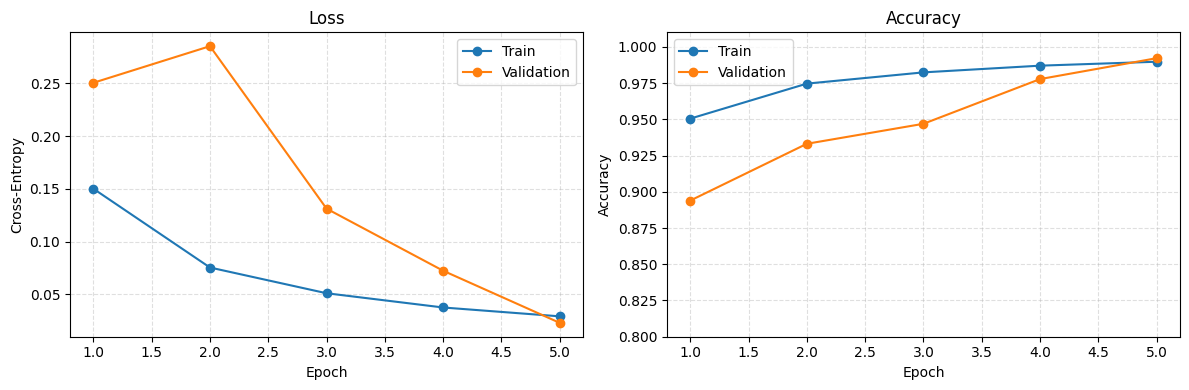

In [15]:
epochs = range(1, NUM_EPOCHS + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(epochs, history["train_loss"], label="Train", marker="o")
axes[0].plot(epochs, history["val_loss"], label="Validation", marker="o")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Cross-Entropy")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.4)

axes[1].plot(epochs, history["train_acc"], label="Train", marker="o")
axes[1].plot(epochs, history["val_acc"], label="Validation", marker="o")
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].set_ylim(0.8, 1.01)
axes[1].grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

In [16]:
save_path = Path(".").resolve() / "vehicle_classifier.pth"
torch.save(vehicle_model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /Users/victorhugogermano/Development/aai-521-final-project-g3/vehicle_classifier.pth


Validation accuracy: 0.9922
              precision    recall  f1-score   support

         car     0.9933    0.9979    0.9956    100748
         van     0.9778    0.9455    0.9614     11327
      others     0.9917    0.9533    0.9721       749
         bus     0.9993    0.9893    0.9943      6832

    accuracy                         0.9922    119656
   macro avg     0.9905    0.9715    0.9808    119656
weighted avg     0.9921    0.9922    0.9921    119656



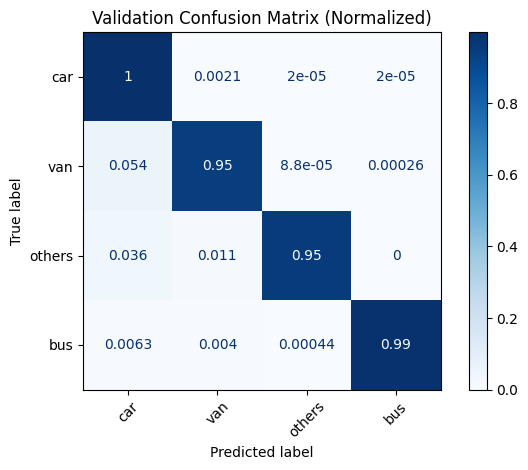

In [18]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
num_classes = len(cnn_dataset["class_to_idx"])
CLASS_NAMES = [cnn_dataset["class_names"][i] for i in range(num_classes)]

vehicle_model.eval()

all_preds, all_targets = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        logits = vehicle_model(xb.to(device))
        all_preds.append(logits.argmax(dim=1).cpu())
        all_targets.append(yb.cpu())

preds = torch.cat(all_preds).numpy()
targets = torch.cat(all_targets).numpy()
target_names = [CLASS_NAMES[i] for i in range(num_classes)]

print(f"Validation accuracy: {(preds == targets).mean():.4f}")
print(classification_report(targets, preds, target_names=target_names, digits=4))

ConfusionMatrixDisplay.from_predictions(
    targets,
    preds,
    display_labels=target_names,
    cmap="Blues",
    xticks_rotation=45,
    normalize="true",
)
plt.title("Validation Confusion Matrix (Normalized)")
plt.tight_layout()
plt.show()

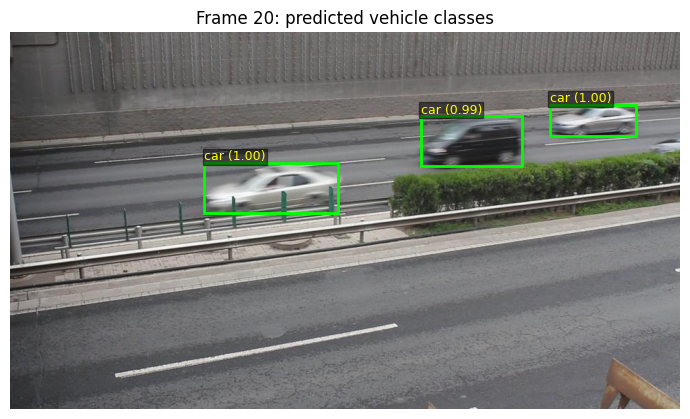

In [23]:
from matplotlib.patches import Rectangle
annon = os.path.join(ANNOTATIONS_PATH,"MVI_40211.xml")
tree = ET.parse(annon)
root = tree.getroot()

frame_path = os.path.join(DETRAC_ROOT,"images", "MVI_40211")
frame_num = 20
frame_info = root.find(f".//frame[@num='{frame_num}']")
frame_image = cv2.cvtColor(cv2.imread(os.path.join(frame_path, f"img{frame_num:05d}.jpg")), cv2.COLOR_BGR2RGB)
h_img, w_img = frame_image.shape[:2]


# Find the specific frame in the XML
frame_info = None
for frame in root.findall(".//frame"):
    if int(frame.attrib["num"]) == frame_num:
        frame_info = frame
        break



vehicle_model.eval()
pred_records = []

with torch.no_grad():
    for target in frame_info.find("target_list").findall("target"):
        box = target.find("box")
        if box is None:
            continue

        left, top = float(box.attrib["left"]), float(box.attrib["top"])
        width, height = float(box.attrib["width"]), float(box.attrib["height"])
        x1, y1 = max(int(left), 0), max(int(top), 0)
        x2, y2 = min(int(left + width), w_img), min(int(top + height), h_img)
        if x2 <= x1 or y2 <= y1:
            continue

        crop = frame_image[y1:y2, x1:x2]
        resized = cv2.resize(crop, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)
        tensor = torch.from_numpy(resized.transpose(2, 0, 1)).unsqueeze(0).float() / 255.0
        probs = torch.softmax(vehicle_model(tensor.to(device)), dim=1).cpu().numpy()[0]
        pred_idx = int(np.argmax(probs))
        pred_records.append(
            {
                "bbox": (x1, y1, x2 - x1, y2 - y1),
                "label": CLASS_NAMES[pred_idx],
                "confidence": float(probs[pred_idx]),
            }
        )

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(frame_image)
for rec in pred_records:
    rect = Rectangle(
        (rec["bbox"][0], rec["bbox"][1]),
        rec["bbox"][2],
        rec["bbox"][3],
        linewidth=2,
        edgecolor="lime",
        facecolor="none",
    )
    ax.add_patch(rect)
    ax.text(
        rec["bbox"][0],
        rec["bbox"][1] - 4,
        f"{rec['label']} ({rec['confidence']:.2f})",
        color="yellow",
        fontsize=9,
        bbox=dict(facecolor="black", alpha=0.5, pad=1),
    )

ax.set_title(f"Frame {frame_num}: predicted vehicle classes")
ax.axis("off")
plt.tight_layout()
plt.show()

In [24]:
sequence_id = "MVI_40211"
frame_indices = range(1, 151)
fps = 12
output_video_path = Path(".") / f"{sequence_id}_predictions.mp4"

annotation_file = Path(ANNOTATIONS_PATH) / f"{sequence_id}.xml"
frame_dir = Path(IMAGES_PATH) / sequence_id
tree = ET.parse(annotation_file)
root = tree.getroot()

first_frame = frame_dir / f"img{frame_indices.start:05d}.jpg"
if not first_frame.exists():
    raise FileNotFoundError(f"Frame not found: {first_frame}")
frame_height, frame_width = cv2.cvtColor(cv2.imread(str(first_frame)), cv2.COLOR_BGR2RGB).shape[:2]

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(str(output_video_path), fourcc, fps, (frame_width, frame_height))

vehicle_model.eval()
with torch.no_grad():
    for frame_num in frame_indices:
        frame_path = frame_dir / f"img{frame_num:05d}.jpg"
        if not frame_path.exists():
            continue
        frame = cv2.cvtColor(cv2.imread(str(frame_path)), cv2.COLOR_BGR2RGB)
        frame_info = root.find(f".//frame[@num='{frame_num}']")
        if frame_info is not None:
            target_list = frame_info.find("target_list")
            if target_list is not None:
                for target in target_list.findall("target"):
                    box = target.find("box")
                    if box is None:
                        continue
                    left = max(int(float(box.attrib["left"])), 0)
                    top = max(int(float(box.attrib["top"])), 0)
                    width = int(float(box.attrib["width"]))
                    height = int(float(box.attrib["height"]))
                    right = min(left + width, frame_width)
                    bottom = min(top + height, frame_height)
                    if right <= left or bottom <= top:
                        continue

                    crop = frame[top:bottom, left:right]
                    resized = cv2.resize(crop, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)
                    tensor = torch.from_numpy(resized.transpose(2, 0, 1)).unsqueeze(0).float() / 255.0
                    probs = torch.softmax(vehicle_model(tensor.to(device)), dim=1).cpu().numpy()[0]
                    pred_idx = int(np.argmax(probs))
                    label = f"{CLASS_NAMES[pred_idx]} {probs[pred_idx]:.2f}"

                    cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)
                    cv2.putText(
                        frame,
                        label,
                        (left, max(top - 5, 0)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (255, 255, 0),
                        1,
                        cv2.LINE_AA,
                    )

        writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

writer.release()
print(f"Saved prediction video to {output_video_path}")

Saved prediction video to MVI_40211_predictions.mp4


In [ ]:
from IPython.display import Video

# video working, just not showing
video_path = Path(".").resolve() / "MVI_40211_predictions.mp4"  
print(video_path)
Video(video_path, width=400)

/Users/victorhugogermano/Development/aai-521-final-project-g3/MVI_40211_predictions.mp4
